In [1]:
import pandas as pd
import seaborn as sns
from scipy.stats import anderson, ttest_ind

У google colab возникали проблемы с кириллицей в файлах, поэтому я в ворде заменил "М" на латинскую M, а "Ж" на F.

В файле оставались пустые строки, которые мешали работать встроенному методу pd.read_csv(), поэтому я создам датасет вручную:

In [2]:
dataset = []
f = open("dataset.txt", "r")
for line in f:
  if line != "\n":
    data = line.split(",")
    data[0] = int(data[0])
    data[1] = int(data[1])
    data[2] = data[2][0]
    dataset.append(data)
df = pd.DataFrame(dataset, columns=["Sick days", "Age", "Gender"])
df.head()

,Sick days,Age,Gender
0,5,39,F
1,4,54,M
2,4,26,M
3,5,42,M
4,4,29,M


По условию задачи нам важно только то, является ли человек старше age лет или нет. Поэтому заменим колонку возраст на условие "Старше ли человек age?" (1, если старше, 0, если младше). Также заменим колонку "Пол" на условие "Является ли данный человек мужчиной?" (1 - мужчина, 0 - женщина).

In [3]:
age = 35
df["Age"] = (df["Age"] > age).astype(int)
df["Gender"] = (df["Gender"] == "M").astype(int)
df.head()

,Sick days,Age,Gender
0,5,1,0
1,4,1,1
2,4,0,1
3,5,1,1
4,4,0,1


Посмотрим на распределение количества пропущенных дней по полу и возрасту

<Axes: xlabel='Sick days', ylabel='count'>

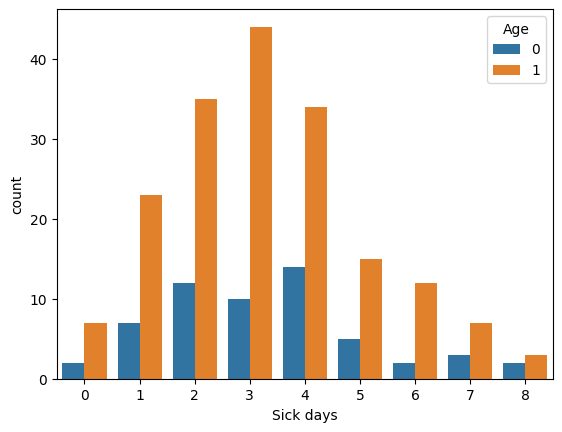

In [12]:
sns.countplot(data=df, x="Sick days", hue="Age")

<Axes: xlabel='Sick days', ylabel='count'>

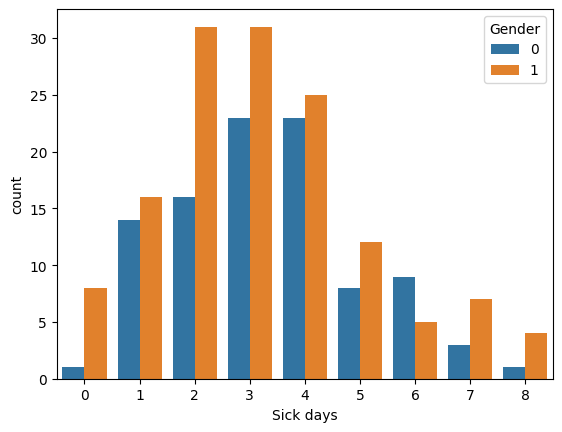

In [13]:
sns.countplot(data=df, x="Sick days", hue="Gender")

Визуально можно предположить, что распределения близки к нормальным.

Мы хотим применить t-тест Стьюдента для проверки гипотезы. Для этого надо формально проверить распределения данных на нормальность. Для этого используем критерий Андерсона-Дарлинга.

In [4]:
anderson(df[df["Gender"] == 0]["Sick days"])

AndersonResult(statistic=1.8820469183320228, critical_values=array([0.555, 0.632, 0.758, 0.884, 1.052]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=3.36734693877551, scale=1.6891879040828495)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

In [5]:
anderson(df[df["Gender"] == 1]["Sick days"])

AndersonResult(statistic=2.7959309619677413, critical_values=array([0.561, 0.638, 0.766, 0.893, 1.063]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=3.179856115107914, scale=1.8891444216400672)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

In [6]:
anderson(df[df["Age"] == 0]["Sick days"])

AndersonResult(statistic=1.1636592227668814, critical_values=array([0.542, 0.617, 0.741, 0.864, 1.028]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=3.3508771929824563, scale=1.8944583476755816)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

In [7]:
anderson(df[df["Age"] == 1]["Sick days"])

AndersonResult(statistic=3.2806061716220825, critical_values=array([0.564, 0.642, 0.77 , 0.899, 1.069]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=3.227777777777778, scale=1.7839462738219733)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

Везде параметр statistic больше, чем критическое значение при уровне значимости 0.05, значит распределения близки к нормальным.

Теперь разобъем данные по полу и возрасту, а также отберём строчки, в которых пропущенных дней больше, чем work_days. Применим к полученным данным t-тест, будем смотреть на его p-value на уровне значимости significance, который по умолчанию будет равен 0.05

In [8]:
work_days = 2
men = df[(df["Gender"] == 1) & (df["Sick days"] > work_days)]["Sick days"]
women = df[(df["Gender"] == 0) & (df["Sick days"] > work_days)]["Sick days"]

In [9]:
significance = 0.05
if ttest_ind(men, women, equal_var=False, alternative="greater", random_state=33).pvalue > significance:
  print("Не можем отвергнуть гипотезу о том, что мужчины пропускают более", work_days, "дней чаще, чем женщины")
else:
  print("Мужчины статистически значимо пропускают более", work_days, "дней чаще, чем женщины")

Не можем отвергнуть гипотезу о том, что мужчины пропускают более 2 дней чаще, чем женщины


In [10]:
old = df[(df["Age"] == 1) & (df["Sick days"] > work_days)]["Sick days"]
young = df[(df["Age"] == 0) & (df["Sick days"] > work_days)]["Sick days"]

In [11]:
if ttest_ind(old, young, equal_var=False, alternative="greater").pvalue > significance:
  print("Не можем отвергнуть гипотезу о том, что старшие пропускают более", work_days, "дней чаще, чем молодые")
else:
  print("Старшие статистически значимо пропускают более", work_days, "дней чаще, чем молодые")

Не можем отвергнуть гипотезу о том, что старшие пропускают более 2 дней чаще, чем молодые


В обоих случаях p-value больше 0.05, поэтому мы не можем отвергнуть гипотезу о том, что среднее количество пропущенных дней больше у мужчин или у людей старше 35.